In [149]:
import pandas as pd 
import requests 
import os 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import torch 
from sklearn.preprocessing import StandardScaler
import plotly.express as px 

%matplotlib inline 

In [61]:
paths1 = "./data/raw/death.csv"
paths2 = "./data/raw/hospital.csv"
paths3 = "./data/raw/severe.csv"
paths4 = "./data/raw/target.csv"

death = pd.read_csv(paths1)
hos = pd.read_csv(paths2)
severe = pd.read_csv(paths3)
target = pd.read_csv(paths4)

In [62]:
death.head()

,Date,Prefecture,Deaths(Cumulative)
0,2020/5/9,ALL,613
1,2020/5/9,Hokkaido,48
2,2020/5/9,Aomori,0
3,2020/5/9,Iwate,0
4,2020/5/9,Miyagi,1


In [63]:
hos.head()

,Date,Prefecture,Requiring inpatient care,Discharged from hospital or released from treatment,To be confirmed
0,2020/5/9,ALL,6250,8276,442
1,2020/5/9,Hokkaido,462,424,0
2,2020/5/9,Aomori,0,17,10
3,2020/5/9,Iwate,0,0,0
4,2020/5/9,Miyagi,8,79,0


In [64]:
severe.head()

,Date,Prefecture,Severe cases
0,2020/5/9,ALL,267
1,2020/5/9,Hokkaido,23
2,2020/5/9,Aomori,0
3,2020/5/9,Iwate,0
4,2020/5/9,Miyagi,0


In [65]:
target.head()

,Date,Prefecture,Newly confirmed cases
0,2020/1/26,ALL,1
1,2020/1/26,Hokkaido,0
2,2020/1/26,Aomori,0
3,2020/1/26,Iwate,0
4,2020/1/26,Miyagi,0


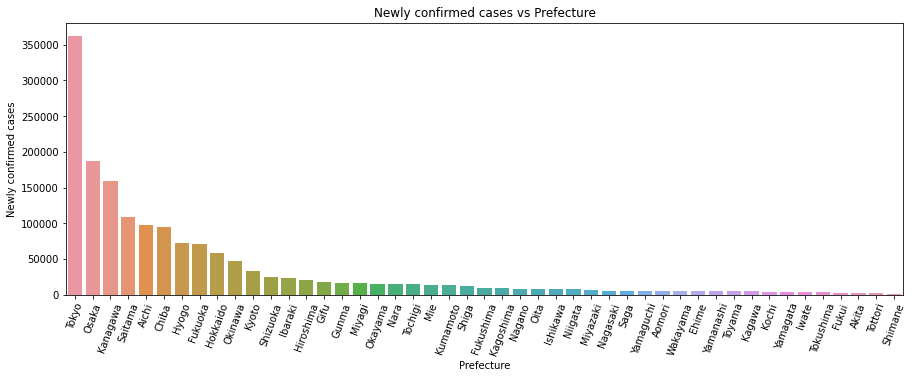

In [66]:
pre = target.groupby("Prefecture").sum().sort_values("Newly confirmed cases", ascending=False).iloc[1:, :].reset_index()
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
sns.barplot(data=pre, x="Prefecture", y="Newly confirmed cases", ax=axes)
plt.xticks(rotation=70)
plt.title("Newly confirmed cases vs Prefecture")
plt.show()

In [108]:
target = target.groupby("Date").sum().reset_index()
hos = hos.groupby("Date").sum().reset_index()
death = death.groupby("Date").sum().reset_index()
severe = severe.groupby("Date").sum().reset_index()
hos_t = pd.merge(target, hos, how="outer", left_on="Date", right_on="Date")
hos_t_d = pd.merge(hos_t, death, how="outer", left_on="Date", right_on="Date")
df = pd.merge(hos_t_d, severe, how="outer", left_on="Date", right_on="Date")
df = df.fillna(0)
df["Date"] = pd.to_datetime(df.Date)
df = df.groupby("Date").sum()
df.head()

,Newly confirmed cases,Requiring inpatient care,Discharged from hospital or released from treatment,To be confirmed,Deaths(Cumulative),Severe cases
Date,,,,,,
2020-01-26,2,0.0,0.0,0.0,0.0,0.0
2020-01-27,0,0.0,0.0,0.0,0.0,0.0
2020-01-28,6,0.0,0.0,0.0,0.0,0.0
2020-01-29,2,0.0,0.0,0.0,0.0,0.0
2020-01-30,6,0.0,0.0,0.0,0.0,0.0


In [109]:
start = df.index.values[0]
end = df.index.values[-1]
print(f"first span {start} - end span {end}")

first span 2020-01-26T00:00:00.000000000 - end span 2021-09-09T00:00:00.000000000


In [110]:
df["datetime"] = df.index
df["day"] = df.datetime.dt.day
df["month"] = df.datetime.dt.month 
df["week"] = df.datetime.dt.weekday 
df["year"] = df.datetime.dt.year
df["q"] = df.datetime.dt.quarter 

df["moving windows 7 days avg"] =  df["Newly confirmed cases"].shift(1).rolling(window=7).mean().fillna(df.loc[(df.year == 2020) & (df.month == 1), "Newly confirmed cases"].mean())
df["moving month avg"] =  df["Newly confirmed cases"].shift(1).rolling(window=30).mean().fillna(df.loc[(df.year == 2020) & (df.month == 1), "Newly confirmed cases"].mean())

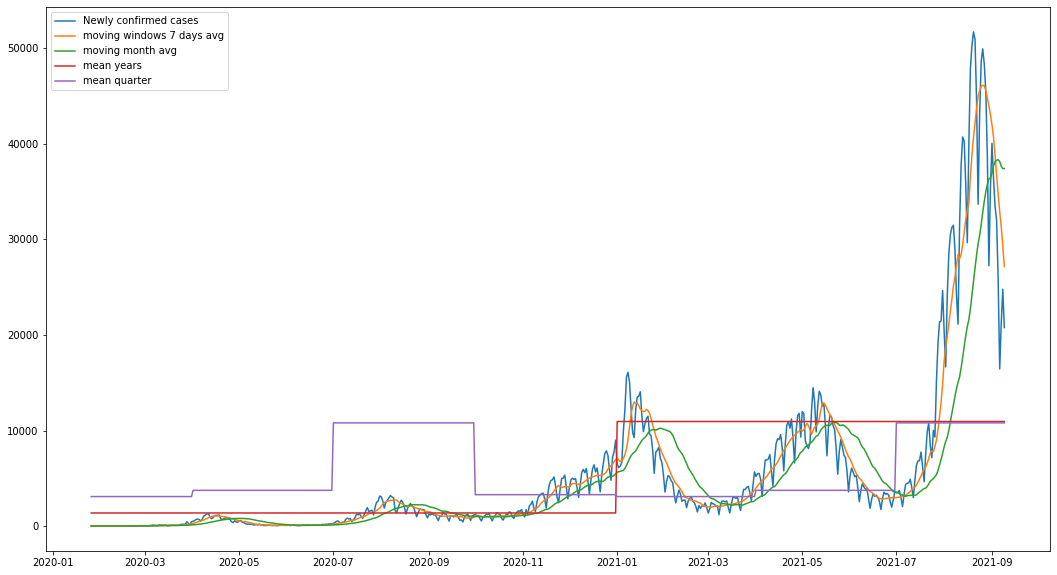

In [115]:
year_avg =  df.groupby("year").mean().loc[:, ["Newly confirmed cases"]]
year_avg = year_avg.rename(columns={"Newly confirmed cases": "mean years"}).reset_index()
df = pd.merge(df, year_avg, how="left", left_on="year", right_on="year")

q_avg =  df.groupby("q").mean().loc[:, ["Newly confirmed cases"]]
q_avg = q_avg.rename(columns={"Newly confirmed cases": "mean quarter"}).reset_index()
df = pd.merge(df, q_avg, how="left", left_on="q", right_on="q")

df.drop(["day", "month", "year", "q"], axis=1, inplace=True)
df = df.set_index("datetime")
plt.figure(figsize=(18, 10))
plt.plot(df[["Newly confirmed cases", "moving windows 7 days avg", "moving month avg", "mean years", "mean quarter"]])
plt.legend(["Newly confirmed cases", "moving windows 7 days avg", "moving month avg", "mean years", "mean quarter"])
plt.show()

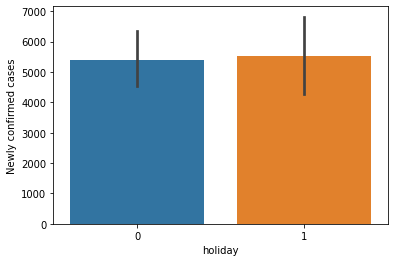

In [118]:
df["holiday"] = df.week.apply(lambda x: 1 if x == 5 or x == 6 else 0)
sns.barplot(data=df, x="holiday", y="Newly confirmed cases")
df.drop(["holiday"], axis=1, inplace=True)

<AxesSubplot:xlabel='week'>

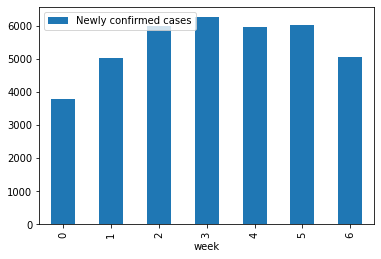

In [123]:
week = df.groupby("week").mean().loc[:, ["Newly confirmed cases"]]
week.plot.bar()

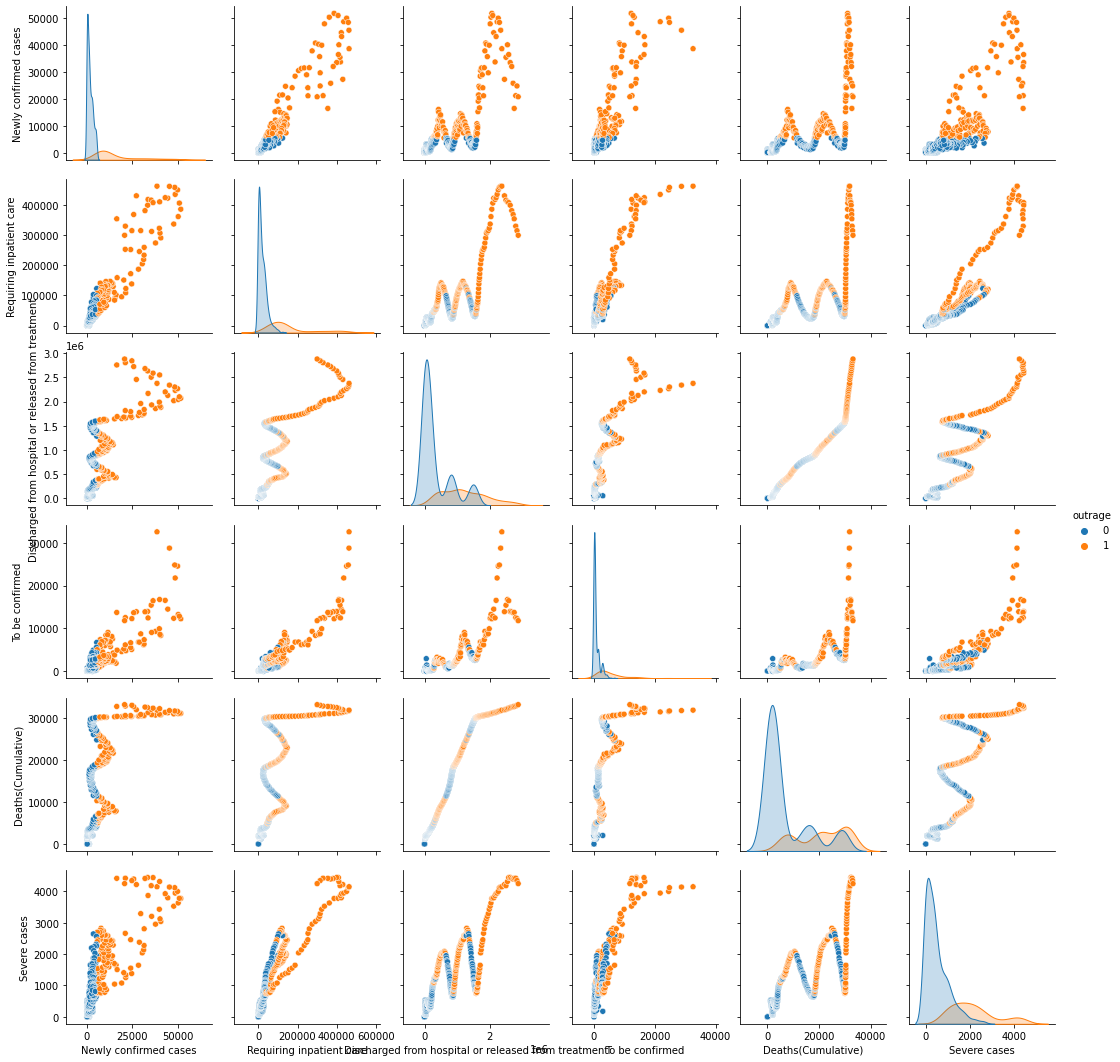

In [133]:
df["outrage"] = (df["Newly confirmed cases"] >= df["Newly confirmed cases"].mean()).astype(int)
sns.pairplot(data=df[["Newly confirmed cases", "Requiring inpatient care", "Discharged from hospital or released from treatment", 
                     "To be confirmed", "Deaths(Cumulative)", "Severe cases", "outrage"]], hue="outrage")
df.drop("outrage", axis=1, inplace=True)

In [137]:
df[["Newly confirmed cases", "Requiring inpatient care", "Discharged from hospital or released from treatment", 
                     "To be confirmed", "Deaths(Cumulative)", "Severe cases"]].corr().style.background_gradient(cmap="coolwarm")

,Newly confirmed cases,Requiring inpatient care,Discharged from hospital or released from treatment,To be confirmed,Deaths(Cumulative),Severe cases
Newly confirmed cases,1.000000,0.950150,0.740688,0.872524,0.647994,0.822087
Requiring inpatient care,0.950150,1.000000,0.789060,0.928705,0.678004,0.921278
Discharged from hospital or released from treatment,0.740688,0.789060,1.000000,0.801130,0.976431,0.844245
To be confirmed,0.872524,0.928705,0.801130,1.000000,0.705092,0.859867
Deaths(Cumulative),0.647994,0.678004,0.976431,0.705092,1.000000,0.775716
Severe cases,0.822087,0.921278,0.844245,0.859867,0.775716,1.000000


In [136]:
df.groupby("outrage").mean()

,Newly confirmed cases,Requiring inpatient care,Discharged from hospital or released from treatment,To be confirmed,Deaths(Cumulative),Severe cases,week,moving windows 7 days avg,moving month avg,mean years,mean quarter
outrage,,,,,,,,,,,
0,1637.822171,18832.205543,3.298645e+05,649.87067,6644.235566,485.986143,2.939954,1688.022325,1924.090531,3759.529645,5201.188181
1,15727.275000,155151.925000,1.227756e+06,5659.76250,20968.087500,2129.487500,3.143750,15019.617857,11603.777500,9985.404147,6083.915735


In [147]:
df["datetime"] = df.index 
df["year"] = df.datetime.dt.year 
df = df[df.year == 2021]
df = df.set_index("datetime")
df.drop("year", axis=1, inplace=True)
df.drop(["mean quarter", "mean years", "moving month avg", "moving windows 7 days avg", "week"], axis=1, inplace=True)
df.head()

,Newly confirmed cases,Requiring inpatient care,Discharged from hospital or released from treatment,To be confirmed,Deaths(Cumulative),Severe cases
datetime,,,,,,
2021-01-01,6496,74374.0,389151.0,2720.0,7026.0,1422.0
2021-01-02,6114,76062.0,393237.0,2686.0,7094.0,1428.0
2021-01-03,6278,77458.0,397599.0,2586.0,7196.0,1462.0
2021-01-04,6660,79810.0,403063.0,2100.0,7308.0,1542.0
2021-01-05,9916,81816.0,410275.0,1818.0,7436.0,1568.0


In [148]:
df.to_csv("./data/processed/train.csv", index=False)